/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-1-bc77d81dca8e>:98: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/3


  0%|          | 0/54 [00:00<?, ?it/s]<ipython-input-1-bc77d81dca8e>:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 54/54 [00:11<00:00,  4.56it/s]


Training Loss: 0.6975, Validation Loss: 1.7682
Epoch 2/3


100%|██████████| 54/54 [00:09<00:00,  5.60it/s]


Training Loss: 0.2350, Validation Loss: 1.0126
Epoch 3/3


100%|██████████| 54/54 [00:09<00:00,  5.56it/s]


Training Loss: 0.1043, Validation Loss: 0.9132


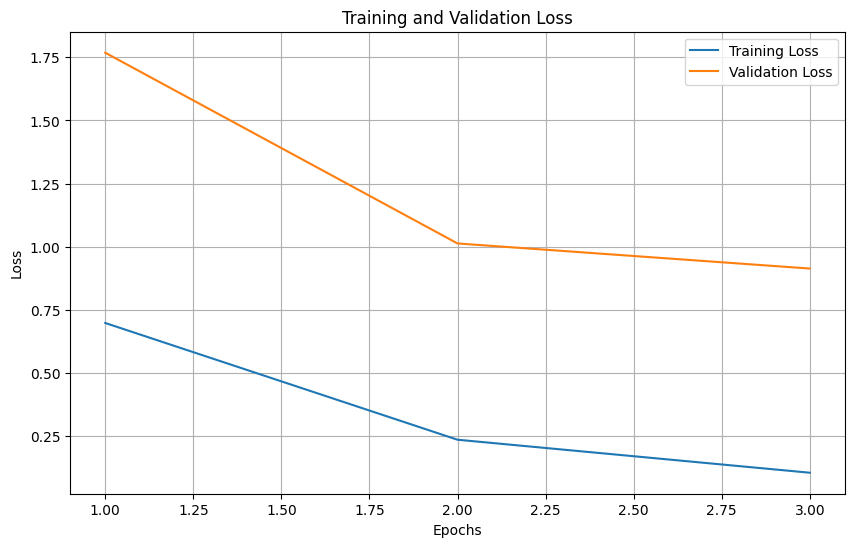

In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader, Dataset
import torch
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
file_path = '/content/drive/MyDrive/new_synonym_replacement.csv'  # Update with your file path
data = pd.read_csv(file_path)

# Drop redundant column if it exists
if 'Unnamed: 0' in data.columns:
    data.drop(columns=['Unnamed: 0'], inplace=True)

# Clean tweets
def clean_tweet(tweet):
    tweet = str(tweet)
    tweet = re.sub(r"http\S+", "", tweet)  # Remove URLs
    tweet = re.sub(r"[^A-Za-z0-9\s]", "", tweet)  # Remove special characters
    tweet = re.sub(r"\s+", " ", tweet).strip()  # Remove extra spaces
    return tweet

data['tweet'] = data['corrected_tweet'].apply(clean_tweet)

# Split dataset
train_data, temp_data = train_test_split(data, test_size=0.3, stratify=data['class'], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['class'], random_state=42)

# Balance the dataset (Oversampling Hate Speech class)
hate_speech = train_data[train_data['class'] == 0]
train_data_balanced = pd.concat([
    train_data,
    resample(hate_speech, replace=True, n_samples=1000, random_state=42)
])

# Tokenizer (RoBERTa)
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

def tokenize_data(data):
    return tokenizer(
        data['tweet'].tolist(),
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

train_encodings = tokenize_data(train_data_balanced)
val_encodings = tokenize_data(val_data)

# Define Dataset class
class HateSpeechDataset(Dataset):
    def __init__(self, tokenized_texts, labels):
        self.tokenized_texts = tokenized_texts
        self.labels = labels.values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.tokenized_texts['input_ids'][idx],
            'attention_mask': self.tokenized_texts['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = HateSpeechDataset(train_encodings, train_data_balanced['class'])
val_dataset = HateSpeechDataset(val_encodings, val_data['class'])

# DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)

# Model (RoBERTa)
model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

# Optimizer, scheduler, and class weights
optimizer = AdamW(model.parameters(), lr=1e-5)
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * 3
)

class_weights = torch.tensor([3.0, 1.0, 2.0], dtype=torch.float).to('cuda')
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training Loop with Loss Tracking
scaler = GradScaler()
epochs = 3
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    print(f"Epoch {epoch + 1}/{epochs}")

    for batch in tqdm(train_dataloader):
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_train_loss += loss.item()

    scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_dataloader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-2-829a02b0cd4d>:101: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/3


  0%|          | 0/107 [00:00<?, ?it/s]<ipython-input-2-829a02b0cd4d>:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 107/107 [00:27<00:00,  3.89it/s]


Training Loss: 0.7006, Validation Loss: 1.5087
Epoch 2/3


100%|██████████| 107/107 [00:20<00:00,  5.32it/s]


Training Loss: 0.2470, Validation Loss: 0.8333
Epoch 3/3


100%|██████████| 107/107 [00:13<00:00,  8.06it/s]


Training Loss: 0.1079, Validation Loss: 0.8318


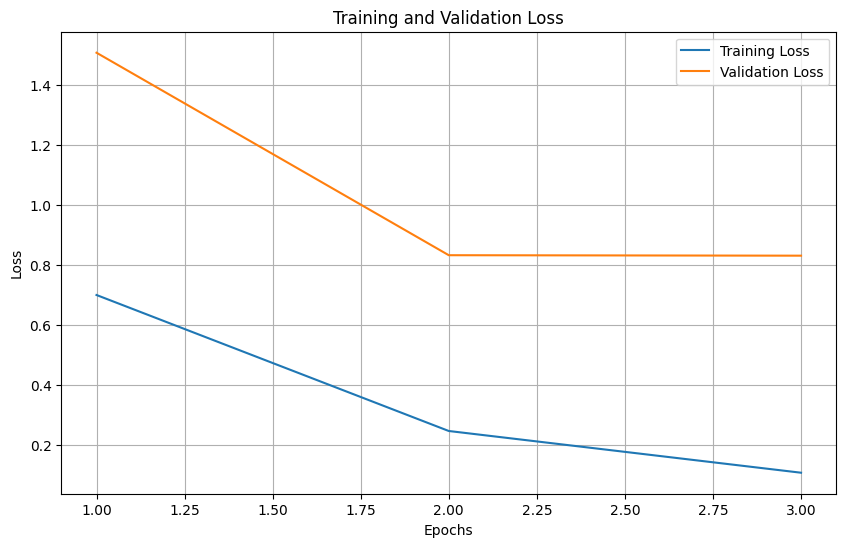

<ipython-input-2-829a02b0cd4d>:174: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Classification Report:
              precision    recall  f1-score   support

 Hate Speech       0.20      0.22      0.21         9
   Offensive       0.90      0.91      0.91       114
     Neutral       0.64      0.59      0.62        27

    accuracy                           0.81       150
   macro avg       0.58      0.58      0.58       150
weighted avg       0.81      0.81      0.81       150



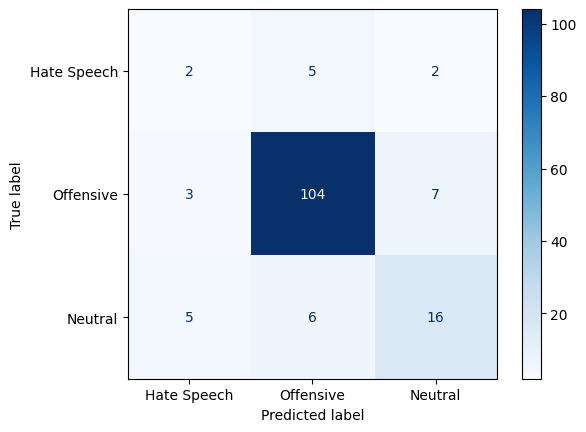

In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader, Dataset
import torch
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
file_path = '/content/drive/MyDrive/new_synonym_replacement.csv'  # Update with your file path
data = pd.read_csv(file_path)

# Drop redundant column if it exists
if 'Unnamed: 0' in data.columns:
    data.drop(columns=['Unnamed: 0'], inplace=True)

# Clean tweets
def clean_tweet(tweet):
    tweet = str(tweet)
    tweet = re.sub(r"http\S+", "", tweet)  # Remove URLs
    tweet = re.sub(r"[^A-Za-z0-9\s]", "", tweet)  # Remove special characters
    tweet = re.sub(r"\s+", " ", tweet).strip()  # Remove extra spaces
    return tweet

data['tweet'] = data['corrected_tweet'].apply(clean_tweet)

# Split dataset
train_data, temp_data = train_test_split(data, test_size=0.3, stratify=data['class'], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['class'], random_state=42)

# Balance the dataset (Oversampling Hate Speech class)
hate_speech = train_data[train_data['class'] == 0]
train_data_balanced = pd.concat([
    train_data,
    resample(hate_speech, replace=True, n_samples=1000, random_state=42)
])

# Tokenizer (RoBERTa)
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

def tokenize_data(data):
    return tokenizer(
        data['tweet'].tolist(),
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

train_encodings = tokenize_data(train_data_balanced)
val_encodings = tokenize_data(val_data)
test_encodings = tokenize_data(test_data)

# Define Dataset class
class HateSpeechDataset(Dataset):
    def __init__(self, tokenized_texts, labels):
        self.tokenized_texts = tokenized_texts
        self.labels = labels.values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.tokenized_texts['input_ids'][idx],
            'attention_mask': self.tokenized_texts['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = HateSpeechDataset(train_encodings, train_data_balanced['class'])
val_dataset = HateSpeechDataset(val_encodings, val_data['class'])
test_dataset = HateSpeechDataset(test_encodings, test_data['class'])

# DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Model (RoBERTa)
model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

# Optimizer, scheduler, and class weights
optimizer = AdamW(model.parameters(), lr=5e-6)
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * 3
)

class_weights = torch.tensor([3.0, 1.0, 2.0], dtype=torch.float).to('cuda')
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training Loop with Loss Tracking
scaler = GradScaler()
epochs = 3
train_losses = []
val_losses = []
early_stop_threshold = 5
no_improvement = 0
best_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    print(f"Epoch {epoch + 1}/{epochs}")

    for batch in tqdm(train_dataloader):
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_train_loss += loss.item()

    scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_dataloader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improvement = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improvement += 1
        if no_improvement >= early_stop_threshold:
            print("Early stopping triggered!")
            break

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Load best model
model.load_state_dict(torch.load('best_model.pth'))

# Test the model
model.eval()
true_labels = []
pred_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predictions.cpu().numpy())

# Confusion Matrix and Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=['Hate Speech', 'Offensive', 'Neutral']))

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Hate Speech', 'Offensive', 'Neutral'])
disp.plot(cmap='Blues')
plt.show()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3


100%|██████████| 54/54 [00:34<00:00,  1.56it/s]


Training Loss: 0.7051, Validation Loss: 1.5852
Epoch 2/3


100%|██████████| 54/54 [00:32<00:00,  1.66it/s]


Training Loss: 0.2172, Validation Loss: 0.7478
Epoch 3/3


100%|██████████| 54/54 [00:32<00:00,  1.64it/s]


Training Loss: 0.0818, Validation Loss: 0.6381


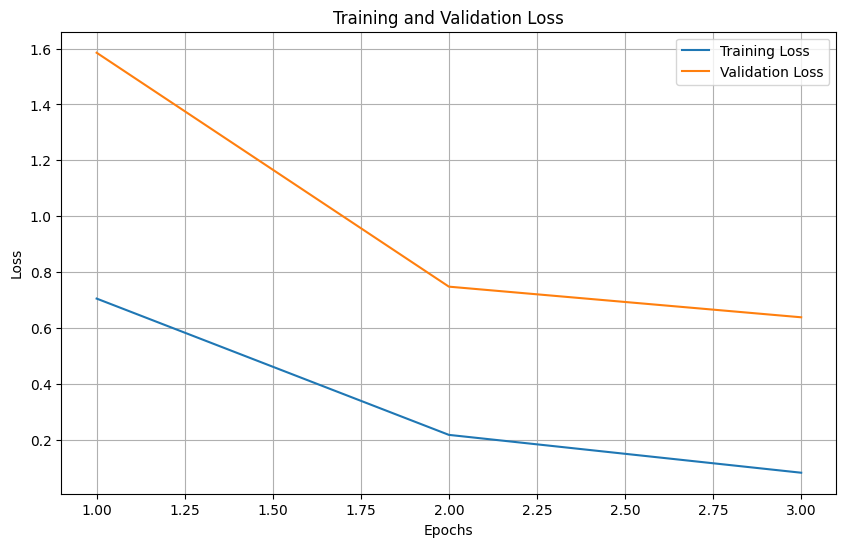

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.11      0.17         9
           1       0.92      0.92      0.92       114
           2       0.76      0.93      0.83        27

    accuracy                           0.87       150
   macro avg       0.67      0.65      0.64       150
weighted avg       0.86      0.87      0.86       150



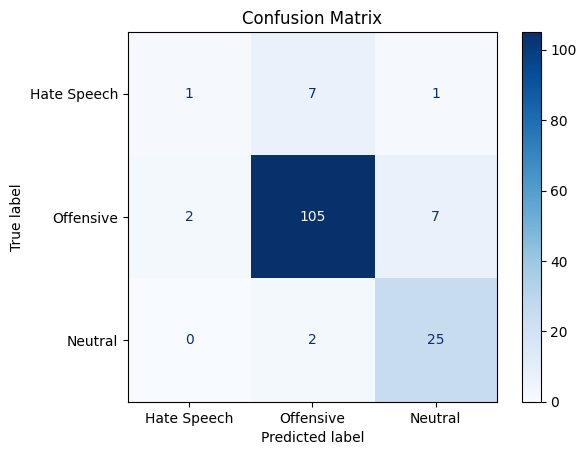

In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader, Dataset
import torch
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
file_path = '/content/drive/MyDrive/new_synonym_replacement.csv'  # Update with your file path
data = pd.read_csv(file_path)

# Drop redundant column if it exists
if 'Unnamed: 0' in data.columns:
    data.drop(columns=['Unnamed: 0'], inplace=True)

# Clean tweets
def clean_tweet(tweet):
    tweet = str(tweet)
    tweet = re.sub(r"http\S+", "", tweet)  # Remove URLs
    tweet = re.sub(r"[^A-Za-z0-9\s]", "", tweet)  # Remove special characters
    tweet = re.sub(r"\s+", " ", tweet).strip()  # Remove extra spaces
    return tweet

data['tweet'] = data['corrected_tweet'].apply(clean_tweet)

# Split dataset
train_data, temp_data = train_test_split(data, test_size=0.3, stratify=data['class'], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['class'], random_state=42)

# Balance the dataset (Oversampling Hate Speech class)
hate_speech = train_data[train_data['class'] == 0]
train_data_balanced = pd.concat([
    train_data,
    resample(hate_speech, replace=True, n_samples=1000, random_state=42)
])

# Tokenizer (RoBERTa)
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

def tokenize_data(data):
    return tokenizer(
        data['tweet'].tolist(),
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

train_encodings = tokenize_data(train_data_balanced)
val_encodings = tokenize_data(val_data)
test_encodings = tokenize_data(test_data)

# Define Dataset class
class HateSpeechDataset(Dataset):
    def __init__(self, tokenized_texts, labels):
        self.tokenized_texts = tokenized_texts
        self.labels = labels.values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.tokenized_texts['input_ids'][idx],
            'attention_mask': self.tokenized_texts['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = HateSpeechDataset(train_encodings, train_data_balanced['class'])
val_dataset = HateSpeechDataset(val_encodings, val_data['class'])
test_dataset = HateSpeechDataset(test_encodings, test_data['class'])

# DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Model (RoBERTa)
model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

# Optimizer, scheduler, and class weights
optimizer = AdamW(model.parameters(), lr=1e-5)
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * 3
)

class_weights = torch.tensor([3.0, 1.0, 2.0], dtype=torch.float).to('cuda')
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training Loop with Loss Tracking
train_losses = []
val_losses = []
epochs = 3

for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    print(f"Epoch {epoch + 1}/{epochs}")

    for batch in tqdm(train_dataloader):
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_dataloader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Evaluation on Test Set
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_dataloader:
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Hate Speech", "Offensive", "Neutral"])
display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-3-67bc13c204bc>:123: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/8


  0%|          | 0/132 [00:00<?, ?it/s]<ipython-input-3-67bc13c204bc>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 132/132 [00:22<00:00,  5.90it/s]


Average training loss: 0.6744
Validation loss: 0.4869
Validation Accuracy: 0.8094
Validation Precision: 0.6721
Validation Recall: 0.8142
Validation F1: 0.6955
Epoch 2/8


  0%|          | 0/132 [00:00<?, ?it/s]<ipython-input-3-67bc13c204bc>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 132/132 [00:21<00:00,  6.11it/s]


Average training loss: 0.4764
Validation loss: 0.4284
Validation Accuracy: 0.8811
Validation Precision: 0.7113
Validation Recall: 0.7989
Validation F1: 0.7466
Epoch 3/8


  0%|          | 0/132 [00:00<?, ?it/s]<ipython-input-3-67bc13c204bc>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 132/132 [00:21<00:00,  6.13it/s]


Average training loss: 0.3765
Validation loss: 0.4454
Validation Accuracy: 0.8433
Validation Precision: 0.6957
Validation Recall: 0.8159
Validation F1: 0.7219
Epoch 4/8


  0%|          | 0/132 [00:00<?, ?it/s]<ipython-input-3-67bc13c204bc>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 132/132 [00:21<00:00,  6.11it/s]


Average training loss: 0.3387
Validation loss: 0.4582
Validation Accuracy: 0.8838
Validation Precision: 0.7135
Validation Recall: 0.7753
Validation F1: 0.7396
Epoch 5/8


  0%|          | 0/132 [00:00<?, ?it/s]<ipython-input-3-67bc13c204bc>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 132/132 [00:21<00:00,  6.11it/s]


Average training loss: 0.2949
Validation loss: 0.4944
Validation Accuracy: 0.8818
Validation Precision: 0.7207
Validation Recall: 0.8098
Validation F1: 0.7507
Epoch 6/8


  0%|          | 0/132 [00:00<?, ?it/s]<ipython-input-3-67bc13c204bc>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 132/132 [00:21<00:00,  6.12it/s]


Average training loss: 0.2601
Validation loss: 0.4299
Validation Accuracy: 0.8896
Validation Precision: 0.7272
Validation Recall: 0.7781
Validation F1: 0.7481
Epoch 7/8


  0%|          | 0/132 [00:00<?, ?it/s]<ipython-input-3-67bc13c204bc>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 132/132 [00:21<00:00,  6.14it/s]


Average training loss: 0.2084
Validation loss: 0.5078
Validation Accuracy: 0.8602
Validation Precision: 0.6962
Validation Recall: 0.8017
Validation F1: 0.7282
Epoch 8/8


  0%|          | 0/132 [00:00<?, ?it/s]<ipython-input-3-67bc13c204bc>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 132/132 [00:21<00:00,  6.11it/s]


Average training loss: 0.1734
Validation loss: 0.5189
Validation Accuracy: 0.8851
Validation Precision: 0.7193
Validation Recall: 0.7756
Validation F1: 0.7418
Early stopping triggered.


<ipython-input-3-67bc13c204bc>:196: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_roberta_model.pth"))


Test Metrics:
Test Accuracy: 0.8786
Test Precision: 0.7196
Test Recall: 0.7996
Test F1: 0.7454


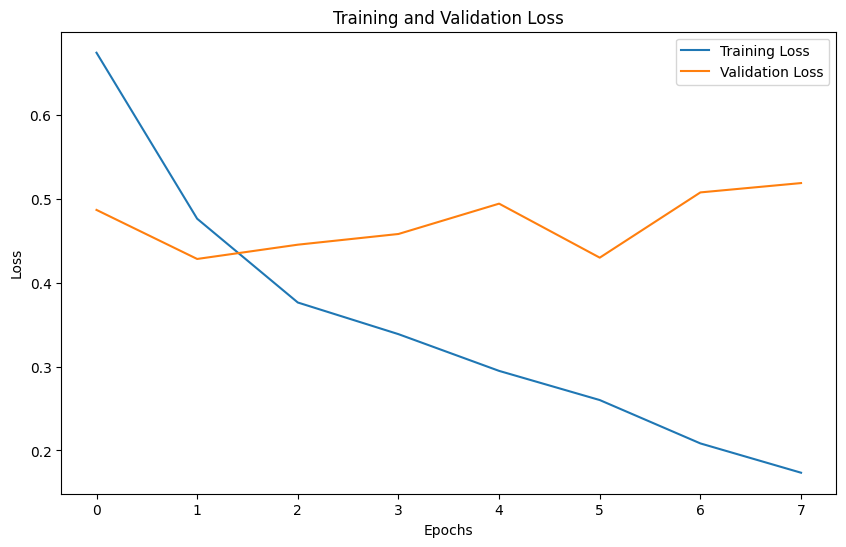

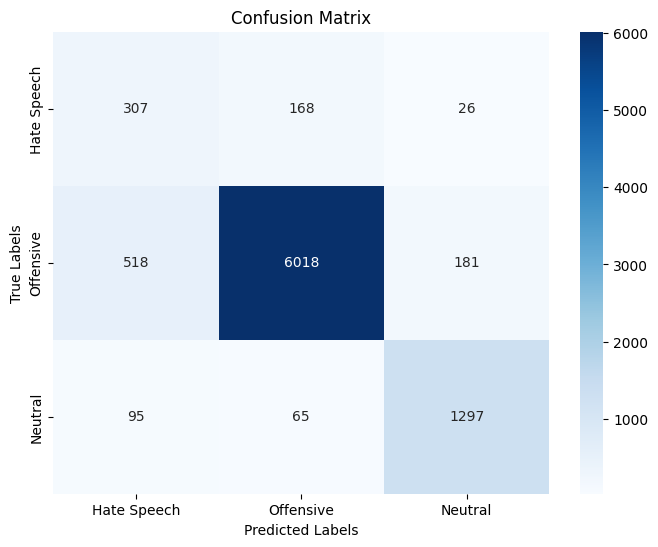

In [3]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.utils import resample
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Step 1: Load dataset
file_path = '/content/drive/MyDrive/labeled_data_cleaned_whole.csv'  # Update with your dataset path
data = pd.read_csv(file_path)

# Drop unnecessary columns if they exist
if 'Unnamed: 0' in data.columns:
    data.drop(columns=['Unnamed: 0'], inplace=True)

# Clean tweets
def clean_tweet(tweet):
    # Convert tweet to string if it's not already
    tweet = str(tweet)
    tweet = re.sub(r"http\S+", "", tweet)  # Remove URLs
    tweet = re.sub(r"[^A-Za-z0-9\s]", "", tweet)  # Remove special characters
    tweet = re.sub(r"\s+", " ", tweet).strip()  # Remove extra spaces
    return tweet

data['tweet'] = data['corrected_tweet'].apply(clean_tweet)

# Step 2: Split dataset
train_data, temp_data = train_test_split(data, test_size=0.7, stratify=data['class'], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['class'], random_state=42)

# Step 3: Balance the dataset (Oversampling Hate Speech class)
hate_speech = train_data[train_data['class'] == 0]
train_data_balanced = pd.concat([
    train_data,
    resample(hate_speech, replace=True, n_samples=1000, random_state=42)
])

# Step 4: Tokenize data
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

def tokenize_data(data):
    return tokenizer(
        data['tweet'].tolist(),
        padding='max_length',
        truncation=True,
        max_length=64,
        return_tensors='pt'
    )

train_encodings = tokenize_data(train_data_balanced)
val_encodings = tokenize_data(val_data)
test_encodings = tokenize_data(test_data)

# Step 5: Define Dataset class
class HateSpeechDataset(Dataset):
    def __init__(self, tokenized_texts, labels):
        self.tokenized_texts = tokenized_texts
        self.labels = labels.values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.tokenized_texts['input_ids'][idx],
            'attention_mask': self.tokenized_texts['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = HateSpeechDataset(train_encodings, train_data_balanced['class'])
val_dataset = HateSpeechDataset(val_encodings, val_data['class'])
test_dataset = HateSpeechDataset(test_encodings, test_data['class'])

# Step 6: Prepare DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Step 7: Define the model
model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

# Step 8: Define optimizer, scheduler, and class weights
optimizer = AdamW(model.parameters(), lr=0.0001)
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * 8
)

class_weights = torch.tensor([3.0, 1.0, 2.0], dtype=torch.float).to('cuda')
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Step 9: Define evaluation function
def evaluate_model(dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
    return accuracy, precision, recall, f1, all_preds, all_labels

# Training with Visualization and Early Stopping
scaler = GradScaler()
accumulation_steps = 2
epochs = 8
best_val_f1 = 0
patience_counter = 0
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    print(f"Epoch {epoch + 1}/{epochs}")

    for batch_idx, batch in enumerate(tqdm(train_dataloader)):
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            loss = loss / accumulation_steps

        scaler.scale(loss).backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps

    scheduler.step()
    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Average training loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    print(f"Validation loss: {avg_val_loss:.4f}")

    # Metrics
    val_accuracy, val_precision, val_recall, val_f1, _, _ = evaluate_model(val_dataloader)
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation F1: {val_f1:.4f}")

    # Early Stopping
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "best_roberta_model.pth")
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= 3:  # Early stopping patience
        print("Early stopping triggered.")
        break

# Step 10: Load Best Model and Test
model.load_state_dict(torch.load("best_roberta_model.pth"))
test_accuracy, test_precision, test_recall, test_f1, test_preds, test_labels = evaluate_model(test_dataloader)
print("Test Metrics:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1: {test_f1:.4f}")

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Hate Speech', 'Offensive', 'Neutral'], yticklabels=['Hate Speech', 'Offensive', 'Neutral'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-6-bf16692733ce>:123: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/8


  0%|          | 0/287 [00:00<?, ?it/s]<ipython-input-6-bf16692733ce>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 287/287 [00:47<00:00,  6.03it/s]


Average training loss: 0.8288
Validation loss: 0.4530
Validation Accuracy: 0.8524
Validation Precision: 0.6885
Validation Recall: 0.7829
Validation F1: 0.7150
Epoch 2/8


  0%|          | 0/287 [00:00<?, ?it/s]<ipython-input-6-bf16692733ce>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 287/287 [00:47<00:00,  6.04it/s]


Average training loss: 0.4737
Validation loss: 0.3787
Validation Accuracy: 0.8828
Validation Precision: 0.7212
Validation Recall: 0.8069
Validation F1: 0.7538
Epoch 3/8


  0%|          | 0/287 [00:00<?, ?it/s]<ipython-input-6-bf16692733ce>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 287/287 [00:47<00:00,  6.07it/s]


Average training loss: 0.4252
Validation loss: 0.3710
Validation Accuracy: 0.8813
Validation Precision: 0.7216
Validation Recall: 0.8186
Validation F1: 0.7560
Epoch 4/8


  0%|          | 0/287 [00:00<?, ?it/s]<ipython-input-6-bf16692733ce>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 287/287 [00:47<00:00,  6.08it/s]


Average training loss: 0.3874
Validation loss: 0.4146
Validation Accuracy: 0.8487
Validation Precision: 0.7105
Validation Recall: 0.8165
Validation F1: 0.7281
Epoch 5/8


  0%|          | 0/287 [00:00<?, ?it/s]<ipython-input-6-bf16692733ce>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 287/287 [00:46<00:00,  6.13it/s]


Average training loss: 0.3616
Validation loss: 0.3608
Validation Accuracy: 0.8906
Validation Precision: 0.7366
Validation Recall: 0.8236
Validation F1: 0.7689
Epoch 6/8


  0%|          | 0/287 [00:00<?, ?it/s]<ipython-input-6-bf16692733ce>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 287/287 [00:47<00:00,  6.06it/s]


Average training loss: 0.3257
Validation loss: 0.4157
Validation Accuracy: 0.8591
Validation Precision: 0.7182
Validation Recall: 0.8035
Validation F1: 0.7323
Epoch 7/8


  0%|          | 0/287 [00:00<?, ?it/s]<ipython-input-6-bf16692733ce>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 287/287 [00:47<00:00,  6.09it/s]


Average training loss: 0.3078
Validation loss: 0.3706
Validation Accuracy: 0.8707
Validation Precision: 0.7206
Validation Recall: 0.8301
Validation F1: 0.7502
Epoch 8/8


  0%|          | 0/287 [00:00<?, ?it/s]<ipython-input-6-bf16692733ce>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 287/287 [00:47<00:00,  6.10it/s]


Average training loss: 0.2834
Validation loss: 0.3803
Validation Accuracy: 0.8934
Validation Precision: 0.7421
Validation Recall: 0.8128
Validation F1: 0.7676
Early stopping triggered.


<ipython-input-6-bf16692733ce>:196: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_roberta_model.pth"))


Test Metrics:
Test Accuracy: 0.8904
Test Precision: 0.7195
Test Recall: 0.7984
Test F1: 0.7515


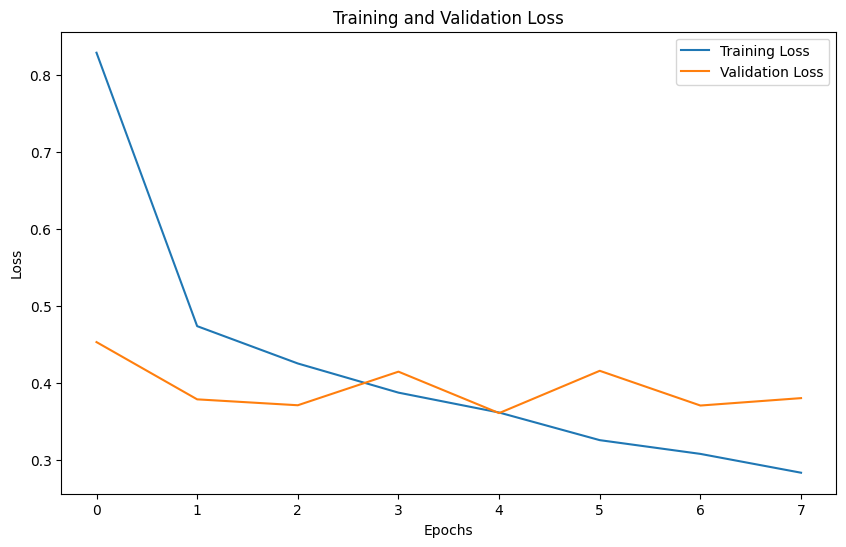

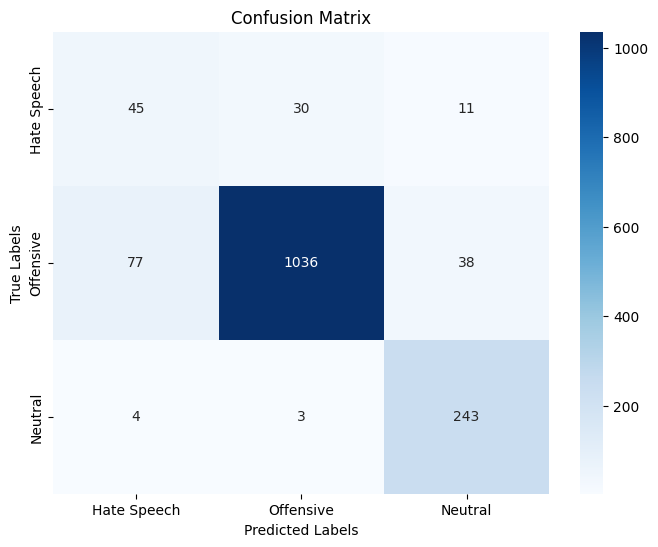

In [6]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.utils import resample
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Step 1: Load dataset
file_path = '/content/drive/MyDrive/labeled_data_cleaned_whole.csv'  # Update with your dataset path
data = pd.read_csv(file_path)

# Drop unnecessary columns if they exist
if 'Unnamed: 0' in data.columns:
    data.drop(columns=['Unnamed: 0'], inplace=True)

# Clean tweets
def clean_tweet(tweet):
    # Convert tweet to string if it's not already
    tweet = str(tweet)
    tweet = re.sub(r"http\S+", "", tweet)  # Remove URLs
    tweet = re.sub(r"[^A-Za-z0-9\s]", "", tweet)  # Remove special characters
    tweet = re.sub(r"\s+", " ", tweet).strip()  # Remove extra spaces
    return tweet

data['tweet'] = data['corrected_tweet'].apply(clean_tweet)

# Step 2: Split dataset
train_data, temp_data = train_test_split(data, test_size=0.3, stratify=data['class'], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.2, stratify=temp_data['class'], random_state=42)

# Step 3: Balance the dataset (Oversampling Hate Speech class)
hate_speech = train_data[train_data['class'] == 0]
train_data_balanced = pd.concat([
    train_data,
    resample(hate_speech, replace=True, n_samples=1000, random_state=42)
])

# Step 4: Tokenize data
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

def tokenize_data(data):
    return tokenizer(
        data['tweet'].tolist(),
        padding='max_length',
        truncation=True,
        max_length=64,
        return_tensors='pt'
    )

train_encodings = tokenize_data(train_data_balanced)
val_encodings = tokenize_data(val_data)
test_encodings = tokenize_data(test_data)

# Step 5: Define Dataset class
class HateSpeechDataset(Dataset):
    def __init__(self, tokenized_texts, labels):
        self.tokenized_texts = tokenized_texts
        self.labels = labels.values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.tokenized_texts['input_ids'][idx],
            'attention_mask': self.tokenized_texts['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = HateSpeechDataset(train_encodings, train_data_balanced['class'])
val_dataset = HateSpeechDataset(val_encodings, val_data['class'])
test_dataset = HateSpeechDataset(test_encodings, test_data['class'])

# Step 6: Prepare DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Step 7: Define the model
model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

# Step 8: Define optimizer, scheduler, and class weights
optimizer = AdamW(model.parameters(), lr=5e-6)
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * 8
)

class_weights = torch.tensor([3.0, 1.0, 2.0], dtype=torch.float).to('cuda')
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Step 9: Define evaluation function
def evaluate_model(dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
    return accuracy, precision, recall, f1, all_preds, all_labels

# Training with Visualization and Early Stopping
scaler = GradScaler()
accumulation_steps = 2
epochs = 8
best_val_f1 = 0
patience_counter = 0
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    print(f"Epoch {epoch + 1}/{epochs}")

    for batch_idx, batch in enumerate(tqdm(train_dataloader)):
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            loss = loss / accumulation_steps

        scaler.scale(loss).backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps

    scheduler.step()
    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Average training loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    print(f"Validation loss: {avg_val_loss:.4f}")

    # Metrics
    val_accuracy, val_precision, val_recall, val_f1, _, _ = evaluate_model(val_dataloader)
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation F1: {val_f1:.4f}")

    # Early Stopping
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "best_roberta_model.pth")
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= 3:  # Early stopping patience
        print("Early stopping triggered.")
        break

# Step 10: Load Best Model and Test
model.load_state_dict(torch.load("best_roberta_model.pth"))
test_accuracy, test_precision, test_recall, test_f1, test_preds, test_labels = evaluate_model(test_dataloader)
print("Test Metrics:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1: {test_f1:.4f}")

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Hate Speech', 'Offensive', 'Neutral'], yticklabels=['Hate Speech', 'Offensive', 'Neutral'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-5-cb10d9b0e607>:124: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/12


  0%|          | 0/287 [00:00<?, ?it/s]<ipython-input-5-cb10d9b0e607>:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 287/287 [00:49<00:00,  5.76it/s]


Average training loss: 1.0571
Validation loss: 0.8494
Validation Accuracy: 0.8195
Validation Precision: 0.6230
Validation Recall: 0.6366
Validation F1: 0.6291
Epoch 2/12


  0%|          | 0/287 [00:00<?, ?it/s]<ipython-input-5-cb10d9b0e607>:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 287/287 [00:47<00:00,  6.07it/s]


Average training loss: 0.6160
Validation loss: 0.4416
Validation Accuracy: 0.8545
Validation Precision: 0.6897
Validation Recall: 0.8025
Validation F1: 0.7241
Epoch 3/12


  0%|          | 0/287 [00:00<?, ?it/s]<ipython-input-5-cb10d9b0e607>:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 287/287 [00:47<00:00,  6.09it/s]


Average training loss: 0.4863
Validation loss: 0.4218
Validation Accuracy: 0.8380
Validation Precision: 0.6882
Validation Recall: 0.8273
Validation F1: 0.7196
Epoch 4/12


  0%|          | 0/287 [00:00<?, ?it/s]<ipython-input-5-cb10d9b0e607>:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 287/287 [00:46<00:00,  6.13it/s]


Average training loss: 0.4446
Validation loss: 0.3972
Validation Accuracy: 0.8475
Validation Precision: 0.6948
Validation Recall: 0.8371
Validation F1: 0.7318
Epoch 5/12


  0%|          | 0/287 [00:00<?, ?it/s]<ipython-input-5-cb10d9b0e607>:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 287/287 [00:47<00:00,  6.07it/s]


Average training loss: 0.4193
Validation loss: 0.4076
Validation Accuracy: 0.8302
Validation Precision: 0.6866
Validation Recall: 0.8346
Validation F1: 0.7170
Epoch 6/12


  0%|          | 0/287 [00:00<?, ?it/s]<ipython-input-5-cb10d9b0e607>:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 287/287 [00:46<00:00,  6.11it/s]


Average training loss: 0.3941
Validation loss: 0.4260
Validation Accuracy: 0.8227
Validation Precision: 0.6931
Validation Recall: 0.8324
Validation F1: 0.7120
Early stopping triggered.


<ipython-input-5-cb10d9b0e607>:197: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_roberta_model.pth"))


Test Metrics:
Test Accuracy: 0.8397
Test Precision: 0.6808
Test Recall: 0.8103
Test F1: 0.7147


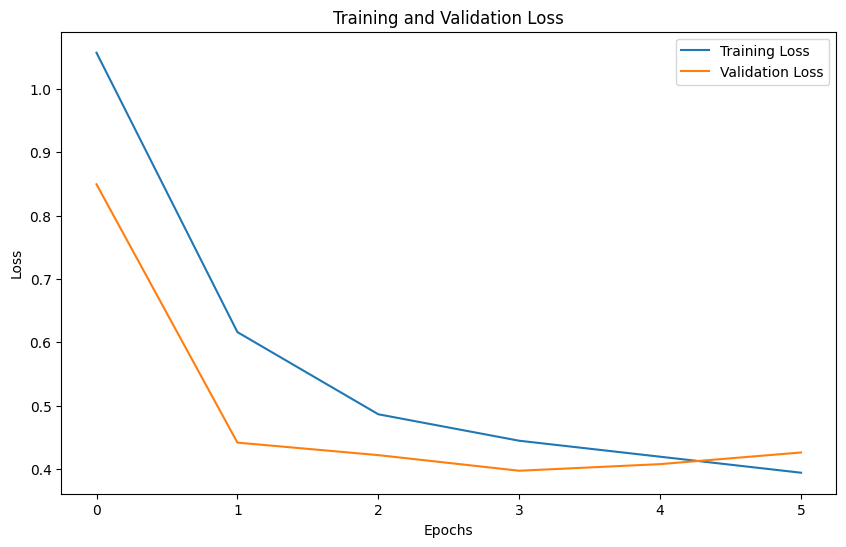

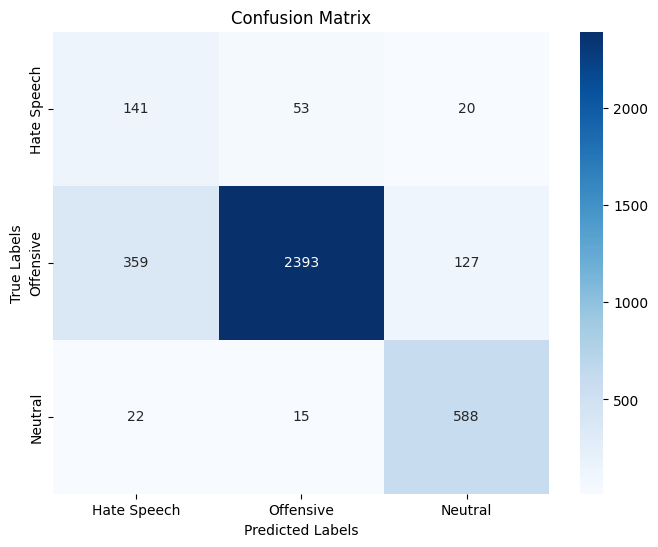

In [5]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.utils import resample
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Step 1: Load dataset
file_path = '/content/drive/MyDrive/labeled_data_cleaned_whole.csv'  # Update with your dataset path
data = pd.read_csv(file_path)

# Drop unnecessary columns if they exist
if 'Unnamed: 0' in data.columns:
    data.drop(columns=['Unnamed: 0'], inplace=True)

# Clean tweets
def clean_tweet(tweet):
    # Convert tweet to string if it's not already
    tweet = str(tweet)
    tweet = re.sub(r"http\S+", "", tweet)  # Remove URLs
    tweet = re.sub(r"[^A-Za-z0-9\s]", "", tweet)  # Remove special characters
    tweet = re.sub(r"\s+", " ", tweet).strip()  # Remove extra spaces
    return tweet

data['tweet'] = data['corrected_tweet'].apply(clean_tweet)

# Step 2: Split dataset
train_data, temp_data = train_test_split(data, test_size=0.3, stratify=data['class'], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['class'], random_state=42)

# Step 3: Balance the dataset (Oversampling Hate Speech class)
hate_speech = train_data[train_data['class'] == 0]
train_data_balanced = pd.concat([
    train_data,
    resample(hate_speech, replace=True, n_samples=1000, random_state=42)
])

# Step 4: Tokenize data
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

def tokenize_data(data):
    return tokenizer(
        data['tweet'].tolist(),
        padding='max_length',
        truncation=True,
        max_length=64,
        return_tensors='pt'
    )

train_encodings = tokenize_data(train_data_balanced)
val_encodings = tokenize_data(val_data)
test_encodings = tokenize_data(test_data)

# Step 5: Define Dataset class
class HateSpeechDataset(Dataset):
    def __init__(self, tokenized_texts, labels):
        self.tokenized_texts = tokenized_texts
        self.labels = labels.values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.tokenized_texts['input_ids'][idx],
            'attention_mask': self.tokenized_texts['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = HateSpeechDataset(train_encodings, train_data_balanced['class'])
val_dataset = HateSpeechDataset(val_encodings, val_data['class'])
test_dataset = HateSpeechDataset(test_encodings, test_data['class'])

# Step 6: Prepare DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Step 7: Define the model
model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

# Step 8: Define optimizer, scheduler, and class weights
optimizer = AdamW(model.parameters(), lr=3e-6)  # Reduced learning rate
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * 12
)

# Adjusted class weights
class_weights = torch.tensor([5.0, 1.0, 3.0], dtype=torch.float).to('cuda')
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Step 9: Define evaluation function
def evaluate_model(dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
    return accuracy, precision, recall, f1, all_preds, all_labels

# Training with Visualization and Early Stopping
scaler = GradScaler()
accumulation_steps = 2
epochs = 12  # Increased epochs
best_val_f1 = 0
patience_counter = 0
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    print(f"Epoch {epoch + 1}/{epochs}")

    for batch_idx, batch in enumerate(tqdm(train_dataloader)):
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            loss = loss / accumulation_steps

        scaler.scale(loss).backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps

    scheduler.step()
    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Average training loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    print(f"Validation loss: {avg_val_loss:.4f}")

    # Metrics
    val_accuracy, val_precision, val_recall, val_f1, _, _ = evaluate_model(val_dataloader)
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation F1: {val_f1:.4f}")

    # Early Stopping
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "best_roberta_model.pth")
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= 2:  # Reduced patience for early stopping
        print("Early stopping triggered.")
        break

# Step 10: Load Best Model and Test
model.load_state_dict(torch.load("best_roberta_model.pth"))
test_accuracy, test_precision, test_recall, test_f1, test_preds, test_labels = evaluate_model(test_dataloader)
print("Test Metrics:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1: {test_f1:.4f}")

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Hate Speech', 'Offensive', 'Neutral'], yticklabels=['Hate Speech', 'Offensive', 'Neutral'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
